In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

In [2]:
users = pd.read_csv('../../baseData/BeerAdvocate/users.csv')
print(users.shape)
users.dropna()
print(users.shape)
users.sample(3)

(153704, 6)
(153704, 6)


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
150938,1,1,slimpikens.777719,slimpikens,1.390388e+09,"United States, Texas"
6222,21,1,belgeko.836363,Belgeko,1.406801e+09,"United States, California"
34432,124,0,cbmccarthy.883468,Cbmccarthy,1.414321e+09,"United States, South Carolina"


5.0


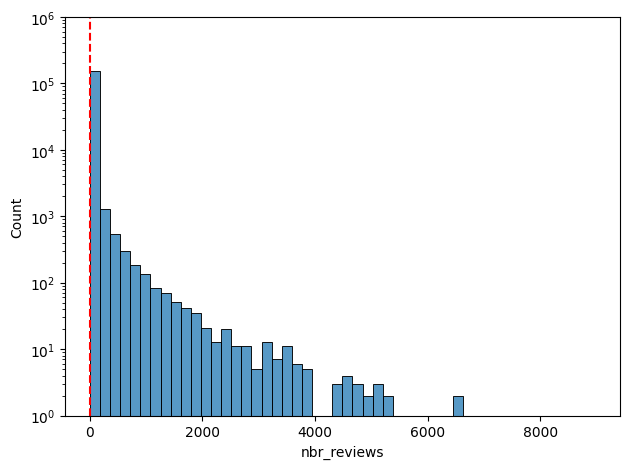

In [3]:
percentile_80 = users['nbr_reviews'].quantile(0.85)
print(percentile_80)
sns.histplot(users['nbr_reviews'], bins=50)
plt.axvline(percentile_80, color='red', linestyle='--', label='80th Percentile')
#plt.xlim(0,5000)
plt.yscale('log')
plt.ylim(1,1000000)
plt.tight_layout()


In [4]:
users_more_than_5_reviews = users[users['nbr_reviews']>=5][['nbr_reviews','user_id']] #85% of our data is lost, oh well
print(users_more_than_5_reviews.shape)
users_more_than_5_reviews.sample(5)

(23162, 2)


,nbr_reviews,user_id
54970,7,jbull.20445
32049,13,beermands.413499
7550,634,becktone.21398
36852,14,pangaeabeerfood.272360
13114,86,wcdoyle.29998


In [5]:
#are they consistent, for now lets just do a bulk analysis, we can further refine later (temporal + cluster analysis)


In [6]:
#reviews.txt is ratings.txt but only where there are reviews, (review: True)
#there are 45 million lines of text... thats a lot
def parse_ratings_file(file_path, limit):
    data = []
    current_block = []
    i = 0

    with open(file_path, 'r') as file:  
        for line in file:
            i += 1
            
            if i%1_000_000 == 0: print('line x million: ', i/1_000_000)
            if i > limit :
                print('Saved first ' + str(limit/1_000_000) + ' million lines')
                break
            
            line = line.strip()  # Remove leading/trailing whitespace
            
            if not line: #if empty line, '' treated as false
                data.append(current_block)
                current_block = []
                continue #next iteration of loop
            
            if ': ' in line:  
                key, value = line.split(': ', 1)  # Split by the first occurrence of ': '
                current_block.append(value)
            

    # Convert the list of lists to a DataFrame
    return pd.DataFrame(data)


ratings_df = parse_ratings_file('../../baseData/BeerAdvocate/reviews.txt', limit = 50_000_000) #takes 8 mins for the whole thing

#since our txt file is in a predicatble format we can make things easy on ourselves
new_column_names = [
    'beer_name',
    'beer_id',
    'brewery_name',  
    'brewery_id',    
    'style',         
    'abv',           
    'date',          
    'user_name',     
    'user_id',       
    'appearance',    
    'aroma',         
    'palate',        
    'taste',         
    'overall',       
    'rating',        
    'text',
]

ratings_df.columns =  new_column_names
# Display the first few rows of the DataFrame
ratings_df.sample(3)


line x million:  1.0
line x million:  2.0
line x million:  3.0
line x million:  4.0
line x million:  5.0
line x million:  6.0
line x million:  7.0
line x million:  8.0
line x million:  9.0
line x million:  10.0
line x million:  11.0
line x million:  12.0
line x million:  13.0
line x million:  14.0
line x million:  15.0
line x million:  16.0
line x million:  17.0
line x million:  18.0
line x million:  19.0
line x million:  20.0
line x million:  21.0
line x million:  22.0
line x million:  23.0
line x million:  24.0
line x million:  25.0
line x million:  26.0
line x million:  27.0
line x million:  28.0
line x million:  29.0
line x million:  30.0
line x million:  31.0
line x million:  32.0
line x million:  33.0
line x million:  34.0
line x million:  35.0
line x million:  36.0
line x million:  37.0
line x million:  38.0
line x million:  39.0
line x million:  40.0
line x million:  41.0
line x million:  42.0
line x million:  43.0
line x million:  44.0


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
1176854,Saranac Our Octoberfest German Style Lager,1522,Matt Brewing Company / Saranac Brewery,99,Märzen / Oktoberfest,5.4,1284285600,KTCamm,ktcamm.289047,4.0,3.5,4.0,4.0,4.0,3.88,Poured from 12 oz bottle into a pint glass.Pou...
2126774,Cornholio,70901,Short's Brewing Company,9629,Baltic Porter,7.0,1317204000,GoldenChild,goldenchild.394643,5.0,4.0,5.0,4.5,4.5,4.46,Not going to make this a drawn out review just...
1460330,Hop Wallop,14916,Victory Brewing Company - Downingtown,345,American Double / Imperial IPA,8.5,1165057200,ngandhi,ngandhi.2474,3.5,4.5,3.5,3.5,2.5,3.54,Did they run out of all that deliciously rich ...


In [7]:
#takes 5 mins to run #only keeping top x reviewers
df_matched = pd.merge(ratings_df, users_more_than_5_reviews, how='inner', on='user_id')
print(df_matched.shape)
df_matched.head(3)

(2523864, 17)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_reviews
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with ...",465
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.0,3.5,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quickl...,2504
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.0,3.5,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim.....",1143


In [8]:
#takes 5 mins to run #sort by id to make visual inspection easier
df_matched_sorted = df_matched.sort_values(by='user_id')
print(df_matched_sorted.shape)
df_matched_sorted.head(3)

(2523864, 17)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_reviews
803986,Green Flash Hop Head Red Ale,35732,Green Flash Brewing Co.,2743,American Amber / Red Ale,8.1,1368266400,--Dom--,--dom--.709199,4.5,4.25,4.25,4.25,4.25,4.27,Poured from a bottle into a pint glass. Awesom...,53
1241564,Modus Hoperandi,48243,Ska Brewing Co.,923,American IPA,6.8,1364810400,--Dom--,--dom--.709199,4.5,4.5,4.25,4.25,4.25,4.33,Poured from a 12 oz can into a pint glass. Pou...,53
396252,Aurora,224173,Omnipollo,25314,American Double / Imperial IPA,7.2,1467626400,--Dom--,--dom--.709199,4.25,4.25,4.25,4.25,4.25,4.25,Pours hazy golden. Bottle conditioned I'm gues...,53


In [9]:
#1min to run
style_counts = df_matched_sorted['style'].value_counts()
print(style_counts)

style
American IPA                        240760
American Double / Imperial IPA      175317
American Double / Imperial Stout    113846
American Pale Ale (APA)             104022
Russian Imperial Stout               78729
                                     ...  
English Pale Mild Ale                 1032
Faro                                   838
Roggenbier                             824
Kvass                                  507
Happoshu                               327
Name: count, Length: 104, dtype: int64


In [10]:
id_counts = df_matched_sorted['user_id'].value_counts()
print(id_counts)

user_id
stonedtrippin.601042    8970
uclabrewn84.439438      8768
sammy.3853              7593
beerchitect.14442       6778
biboergosum.168458      6616
                        ... 
t-sizzle.1201753           5
eatsoutalot.884668         5
ebeard2.613254             5
t1i1m1.888088              5
beerfandan17.160184        5
Name: count, Length: 23162, dtype: int64


In [11]:
#lets focus on the top user for now, stonedtrippin.601042
df_stoned = df_matched_sorted[df_matched_sorted['user_id'] == 'stonedtrippin.601042']
print(df_stoned.shape)
df_stoned.head(3)

(8970, 17)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_reviews
1713862,#Merica,181536,Surly Brewing Co. Beer Hall,13014,American Adjunct Lager,5.0,1465984800,StonedTrippin,stonedtrippin.601042,3.75,3.5,3.75,3.5,3.5,3.54,apparently designed for the budweiser drinkers...,8970
1845343,Jodi's Bananas,226434,Bangin' Banjo Brewing Company,41604,American Amber / Red Ale,5.3,1488106800,StonedTrippin,stonedtrippin.601042,3.75,3.75,4.0,3.75,3.75,3.78,one of the weirdest ideas i have heard of for ...,8970
2155400,Impasse Saison,94379,Crux Fermentation Project,29415,Saison / Farmhouse Ale,6.6,1438077600,StonedTrippin,stonedtrippin.601042,3.75,3.5,4.0,3.75,3.75,3.72,its cool to have these guys in the colorado ma...,8970


In [12]:
stoned_style_counts = df_stoned['style'].value_counts()
print(stoned_style_counts)
#only keep styles with more than 5 reviews
styles_to_keep = stoned_style_counts[stoned_style_counts > 200].index
df_stoned_filtered = df_stoned[df_stoned['style'].isin(styles_to_keep)]
df_stoned_filtered['style'].value_counts()
#only goes down to 98 for more than 5, might as well keep all of em... (more than 1 review)
#nah lets look at the top whatver for a better box plot

style
American IPA                      901
Saison / Farmhouse Ale            767
American Wild Ale                 721
American Double / Imperial IPA    413
American Pale Ale (APA)           413
                                 ... 
Euro Strong Lager                   4
American Malt Liquor                2
Roggenbier                          2
Kvass                               1
Faro                                1
Name: count, Length: 103, dtype: int64


style
American IPA                        901
Saison / Farmhouse Ale              767
American Wild Ale                   721
American Pale Ale (APA)             413
American Double / Imperial IPA      413
American Double / Imperial Stout    349
American Porter                     289
American Amber / Red Ale            216
Fruit / Vegetable Beer              205
Name: count, dtype: int64

C:\Users\Enzo\AppData\Local\Temp\ipykernel_30696\3108241543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stoned_filtered['rating'] = df_stoned_filtered['rating'].astype(float) #seaborn isnt happy otherwise


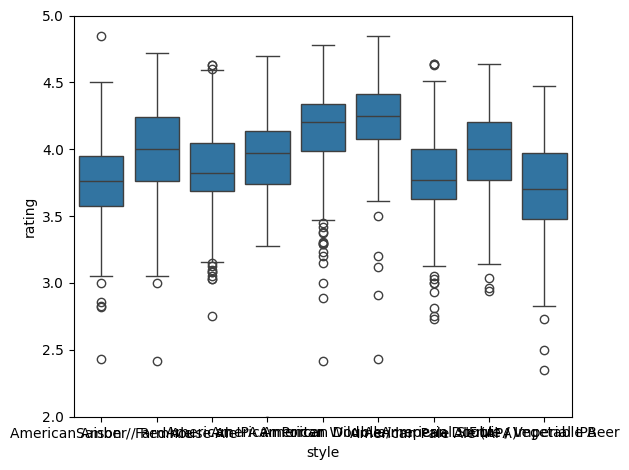

In [13]:
df_stoned_filtered['rating'] = df_stoned_filtered['rating'].astype(float) #seaborn isnt happy otherwise
sns.boxplot(x='style',y='rating',data=df_stoned_filtered)
plt.xticks(rotation=0)
plt.ylim(2, 5)
plt.tight_layout()

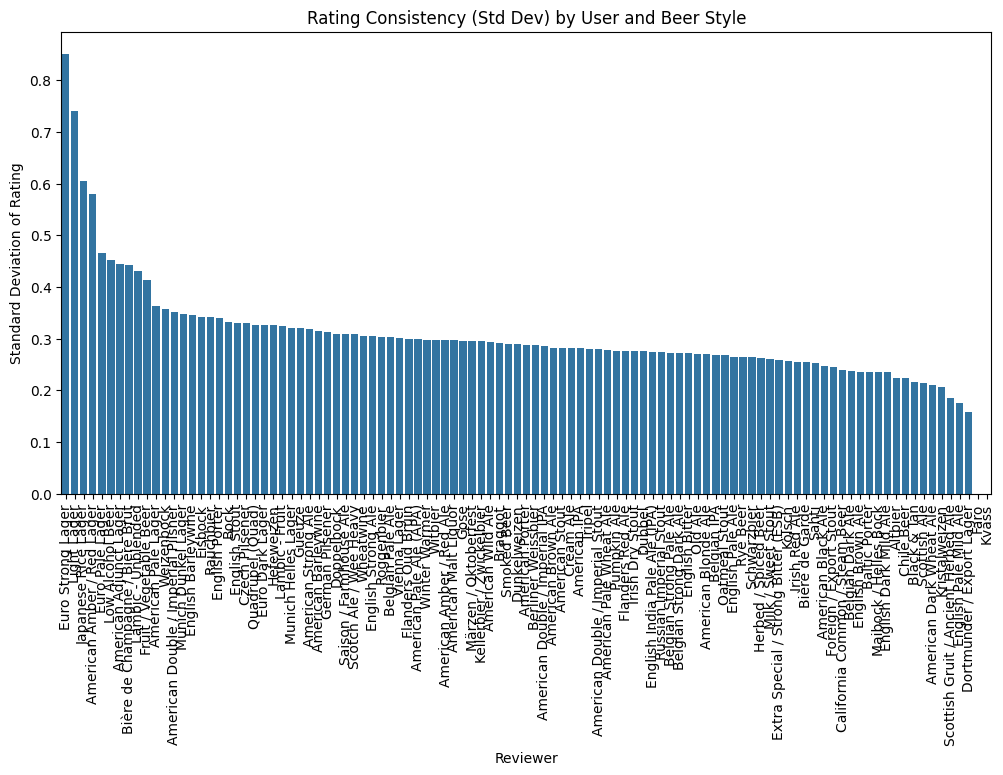

In [ ]:
# Calculate standard deviation of ratings for each reviewer and style
consistency_df = df_stoned.groupby('style')['rating'].std().reset_index()
consistency_df.columns = ['style', 'rating_std_dev']
consistency_df = consistency_df.sort_values('rating_std_dev', ascending=False)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='style', y='rating_std_dev', data=consistency_df)
plt.xticks(rotation=90)
plt.title('Rating Consistency (Std Dev) by Beer Style')
plt.ylabel('Standard Deviation of Rating')
plt.xlabel('Reviewer')
plt.show()

In [15]:
df_std_dev = df_matched_sorted.groupby('user_id')['rating'].std().reset_index()
df_std_dev.columns = ['user_id', 'rating_std_dev']
df_std_dev = df_std_dev.sort_values('rating_std_dev', ascending=False)


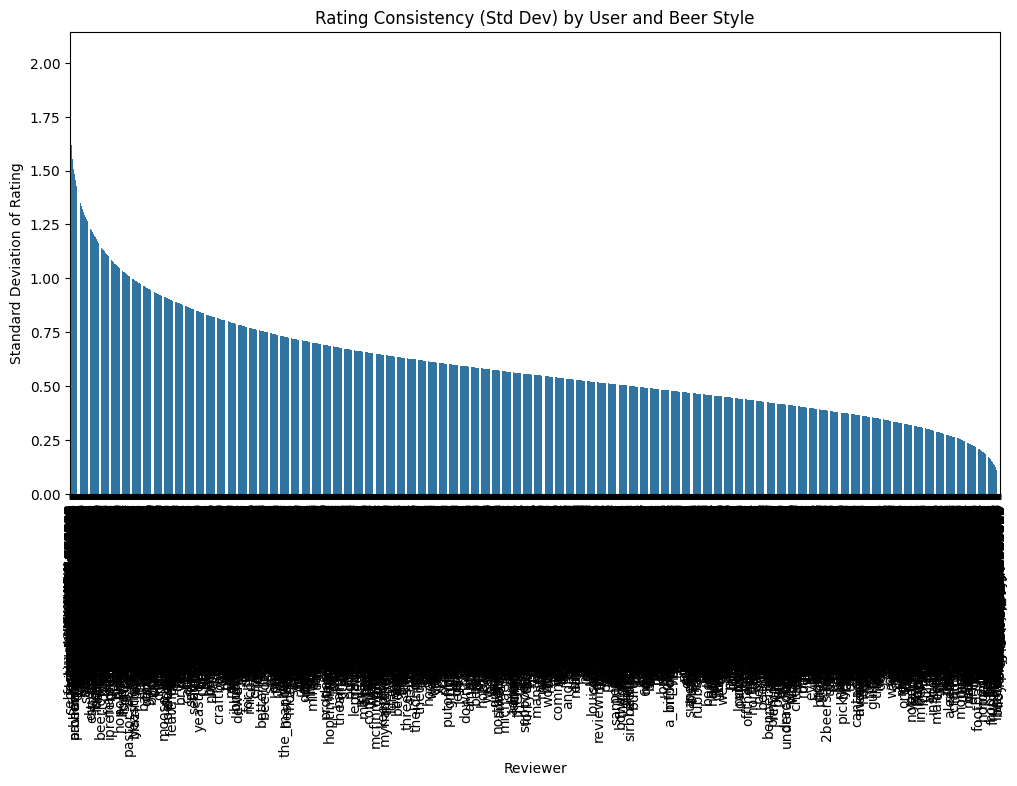

In [ ]:
#takes 10 mins to run...
df_std_dev_small = df_std_dev.head(500)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='rating_std_dev', data=df_std_dev)
plt.xticks(rotation=90)
plt.title('Rating Consistency (Std Dev) by User and Beer Style')
plt.ylabel('Standard Deviation of Rating')
plt.xlabel('Reviewer')
plt.show()

In [19]:
df_std_dev.sample(10)

,user_id,rating_std_dev
8305,gibby.237528,0.467820
5733,dbriesemeister.56879,0.389862
21237,tippiecanoes.799948,1.457762
18984,shir0043.338358,0.794205
19969,stezz420.869052,1.192214
17079,psychonautica.750311,0.790898
9009,harsley.24484,0.879815
13888,mbmiche.843284,0.472385
11072,jmalex.27940,0.480287
16529,penguin3200.281501,0.508925
